---
title: "Grouping Problems with SQL"
bibliography: "../../blog.bib"
author: "Peter Amerkhanian"
date: "2024-11-20"
description: "An overview of `GROUP BY` and `PARTITION BY` statements in SQL."
draft: false
categories:  ['SQL', 'Data Management']
format:
  html:
    toc: true
    toc-depth: 3
    code-fold: false
    code-tools: true
    code-line-numbers: true
---

In [117]:
#| code-line-numbers: false
import duckdb
import pandas as pd
import numpy as np
import random
from IPython.display import display, Markdown

Lately I've been struggling through some SQL query development, and I thought it would be useful to write out some of what I've been learning in a blog post. Specifically, I've been thinking about how to do various grouping tasks when data have a hierarchical structure. I'll cover the following SQL concepts:  

- The `GROUP BY` clause
- The `PARTITION BY` clause
- An aggregation task complicated by a dataset's hierarchy

This post is also an opportunity to overview how I display **and** run SQL code with syntax highlighting in Quarto -- a nontrivial task as it turns out!

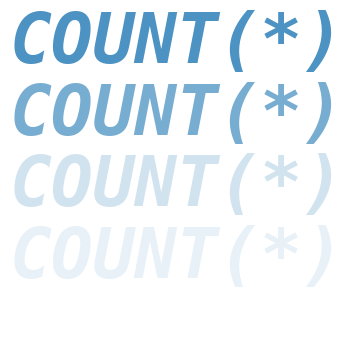

In [118]:
#| output: false
#| echo: false
import matplotlib.pyplot as plt
# Create a blank plot
fig, ax = plt.subplots(figsize=(3, 3.5))
size = 50
space = .25
start = 1
ax.text(
    0.5, start,
    "COUNT(*)",
    color= "tab:blue",
    fontsize=size,
    ha='center',
    weight="bold",
    style='italic',
    va='center',
    fontfamily='monospace',
    alpha=.8
)
ax.text(
    0.5, start-space,
    "COUNT(*)",
    color= "tab:blue",
    fontsize=size,
    ha='center',
    weight="bold",
    style='italic',
    va='center',
    fontfamily='monospace',
    alpha=.6
)
ax.text(
    0.5, start - space*2,
    "COUNT(*)",
    color= "tab:blue",
    fontsize=size,
    weight="bold",
    style='italic',
    ha='center',
    va='center',
    fontfamily='monospace',
    alpha=.2
)
ax.text(
    0.5, start - space*3,
    "COUNT(*)",
    color= "tab:blue",
    fontsize=size,
    weight="bold",
    style='italic',
    ha='center',
    va='center',
    fontfamily='monospace',
    alpha=.1
)

ax.set_axis_off()
fig.tight_layout()
fig.savefig('thumbnail.png', bbox_inches='tight', dpi=300)

To start, I'll synthesize a simple dataset that examines car accidents on the Interstate 280 and 580 highways in the Bay Area. I'll go over the specifics later, but for now just note that this is a standard `pandas` dataframe stored in local memory as `accidents`. It contains data on cars' trips on the two highways, and a flag denoting whether the trip was associated with an accident or not.

In [119]:
#| output: false
#| code-line-numbers: false
np.random.seed(42)
n = 1000
data = {
    "license_plate": [f"{random.randint(90000, 90099)}" for _ in range(n)],
    "highway": [random.choice(["I280", "I580"]) for _ in range(n)],
    "trip_date": [f"2024-11-{random.randint(12, 15)}" for _ in range(n)],
    "accident_flag": np.random.binomial(1, .05, n),
}
accidents = pd.DataFrame(data)
mask = (accidents["highway"] == "I580") & (accidents["trip_date"] == "2024-11-14")
accidents.loc[mask, "accident_flag"] = np.random.binomial(1, 0.6, mask.sum())

## Connecting to a `pandas` data frame in `duckdb`
The data I simulated are quite small, so using SQL isn't going to be very practically useful. However, I find that it's helpful to play with small SQL databases like this to build general comfort with the language and to get a better intuition of how operations will play out when I'm are working at scale. 

I'm going to use the [`duckdb` database system](https://duckdb.org/) to directly query the `pandas` data frame I have in local memory (Note that `duckdb` can also directly query [parquet files, csv files, and more](https://duckdb.org/docs/api/python/overview.html#data-input)).

In [120]:
#| code-line-numbers: false
duckdb.sql("SELECT * FROM accidents LIMIT 5;")

┌───────────────┬─────────┬────────────┬───────────────┐
│ license_plate │ highway │ trip_date  │ accident_flag │
│    varchar    │ varchar │  varchar   │     int32     │
├───────────────┼─────────┼────────────┼───────────────┤
│ 90073         │ I280    │ 2024-11-13 │             0 │
│ 90017         │ I280    │ 2024-11-15 │             1 │
│ 90067         │ I580    │ 2024-11-12 │             0 │
│ 90093         │ I580    │ 2024-11-15 │             0 │
│ 90000         │ I280    │ 2024-11-12 │             0 │
└───────────────┴─────────┴────────────┴───────────────┘

### Executing and displaying SQL in Quarto

The fact that `duckdb` can directly query data in memory is great, but two issues arise -- the SQL code doesn't have any syntax highlighting, and it would be preferable if the output were a data frame rather than plain text. I'll create a wrapper function, `run_query` that solves these issues:


In [121]:
#| code-line-numbers: false
def run_query(sql_str: str) -> pd.DataFrame:
  display(Markdown("```sql\n" + sql_str.strip("\n") + "\n```"))
  return duckdb.sql(sql_str).df()


Note the following code elements:  

1. `display(Markdown(...))`  will display `sql_str`, the string code for the query, but with a wrapper around it as follows:  

```{{sql}}  
sql_str 
```  

The wrapper alerts Quarto that it should provide SQL syntax-highlighting for the code output.  

2. `duckdb.sql(sql_str).df()` returns the results of the SQL query as a `pd.DataFrame` object rather than the text-table rendered above.  


For the rest of the post, I will use that function, within cells with the setting `echo: false` to carry out my SQL queries. Thus, you won't see the python function, just a code chunk of the SQL query code and the query result. Here's an example query, looking at the first five rows of `accidents`:

In [122]:
#| echo: false
run_query(
"""--sql
SELECT * FROM accidents
LIMIT 5;
""")

```sql
--sql
SELECT * FROM accidents
LIMIT 5;
```

,license_plate,highway,trip_date,accident_flag
0,90073,I280,2024-11-13,0
1,90017,I280,2024-11-15,1
2,90067,I580,2024-11-12,0
3,90093,I580,2024-11-15,0
4,90000,I280,2024-11-12,0


Note the hierarchy of these trip data:

::: {.mermaid-desktop-only}
```{mermaid}
%%| label: fig-data
%%| fig-cap: "Trip data hierarchy"

flowchart LR

    A[Date] --> B[Highway]
    B --> C[Car<br/>license plate]
    C --> D(["`**Trip**`"])
    D o-.-o E[Accident Flag]
    
    A1>Multiple highways<br/>per date] -.-> B
    B1>Multiple cars<br/>per highway] -.-> C
    C1>Multiple trips<br/>per car] -.-> D
```
:::

::: {.mermaid-mobile-only}
```{mermaid}
%%| label: fig-data
%%| fig-cap: "Trip data hierarchy"

flowchart TD

    A[Date] --> B[Highway]
    B --> C[Car<br/>license plate]
    C --> D(["`**Trip**`"])
    D o-.-o E[Accident Flag]
    
    A1>"`*Multiple highways<br/>per date*`"] -.- B
    B1>"`*Multiple cars<br/>per highway*`"] -.- C
    C1>"`*Multiple trips<br/>per car*`"] -.- D
```
:::


We start with Dates and proceed downward. Each Date can have multiple Highways, each Highway can have multiple Cars (identified by license plate), and each Car can have multiple Trips. Trips are the lowest granularity of the data -- each row is a trip. Individual trips are then described by the accident flag column, which denotes whether the trip was associated with an accident or not.


I'll look at a few key SQL methods using these data.

## Aggregating with `GROUP BY`
Let's say we were interested in counting total trips and total accidents for each highway on each day. This is a group aggregation task, where we want to calculate summary statistics (two counts) for subsets of the data grouped by one or more columns. In SQL this is done using the `GROUP BY` clause and an aggregation function (`COUNT` and `SUM` in this case).  

::: {.mermaid-desktop-only}
```{mermaid}
%%| label: fig-groupby
%%| fig-cap: "A diagram of GROUP BY"

flowchart LR
A[(row:<br>1k<br>col:<br>4)] --select --> B[Date]
A --select --> C[Highway]
A--select --> P[Accident<br>Flag]
    B --> E[Group<br>By]
    C --> E
    subgraph sql ["SQL Grouping Operations"]
    E --> M[Agg-<br>regate]
    M --> F["Count rows<br/>COUNT(*)"]
    M --> G["Count accidents<br/>SUM(accident_flag)"]
    end
    P --> M
    F --> Q[("row: <br>n(highway) X n(date)<br>col:<br>4")]
    G --> Q


style sql fill:none
```
:::

::: {.mermaid-mobile-only}
```{mermaid}
%%| label: fig-groupby
%%| fig-cap: "A diagram of GROUP BY"

flowchart TD
A[(row:<br>1k<br>col:<br>4)] --select --> B[Date]
A --select --> C[Highway]
A--select --> P[Accident<br>Flag]
    B --> E[Group<br>By]
    C --> E
    subgraph sql ["SQL Grouping Operations"]
    E --> M[Agg-<br>regate]
    M --> F["Count rows<br/>COUNT(*)"]
    M --> G["Count accidents<br/>SUM(accident_flag)"]
    end
    P --> M
    F --> Q[("row: <br>n(highway) X n(date)<br>col:<br>4")]
    G --> Q


style sql fill:none
```
:::

Equivalent `pandas` code is available via the navbar. In this case, I like the SQL and `pandas` syntax about equally.

::: {.panel-tabset}

## SQL

In [123]:
#| echo: false
run_query("""--sql
SELECT
  highway,
  trip_date,
  COUNT(*) as n_trips,
  SUM(accident_flag) as n_accidents
FROM
  accidents
GROUP BY
  highway,
  trip_date
ORDER BY
  highway,
  trip_date
""")

```sql
--sql
SELECT
  highway,
  trip_date,
  COUNT(*) as n_trips,
  SUM(accident_flag) as n_accidents
FROM
  accidents
GROUP BY
  highway,
  trip_date
ORDER BY
  highway,
  trip_date
```

,highway,trip_date,n_trips,n_accidents
0,I280,2024-11-12,135,7.0
1,I280,2024-11-13,123,1.0
2,I280,2024-11-14,119,6.0
3,I280,2024-11-15,142,7.0
4,I580,2024-11-12,125,6.0
5,I580,2024-11-13,120,2.0
6,I580,2024-11-14,115,61.0
7,I580,2024-11-15,121,9.0


## Equivalent `pandas` code

In [124]:
(
    accidents
    .groupby(['highway', 'trip_date'], as_index=False)
    .agg(
        n_trips=('trip_date', 'size'),
        n_accidents_date_highway=('accident_flag', 'sum')
    )
    .sort_values(by=['highway', 'trip_date'])
)


,highway,trip_date,n_trips,n_accidents_date_highway
0,I280,2024-11-12,135,7
1,I280,2024-11-13,123,1
2,I280,2024-11-14,119,6
3,I280,2024-11-15,142,7
4,I580,2024-11-12,125,6
5,I580,2024-11-13,120,2
6,I580,2024-11-14,115,61
7,I580,2024-11-15,121,9


:::

Note that the `GROUP BY` operation reduces our data granularity down to the unique highway-date pairs. This is typical aggregation behavior. Also note in lines 4 and 5 of the SQL code, that for accidents, I use `COUNT(*)`. This simply counts all rows within the group. In the case of the accident flags, I use `SUM(accident_flag)` within groups since the column is a 1/0 integer flag.

## Aggregating with `PARTITION BY`

The Partition is an odd cousin of the Group that I became aware of only recently. In essence, it accomplishes the same thing as `GROUP BY`, but it doesn't compress the data or otherwise change granularity. Instead, it returns a dataframe with a group's aggregate result replicated at every row where that group exists.  

Note the bold portions in the diagram below. The SQL grouping operations look basically the same as when we were using `GROUP BY` and we will get the same highway-date level aggregates from those operations. However, we have a very different row count in the output, and we are able to still select columns, in this case License Plate, that were not part of the grouping operation. This is because the output rows are still at the trip level, not the highway-date level.
  

::: {.mermaid-desktop-only}
```{mermaid}
%%| label: fig-partition
%%| fig-cap: "A diagram of PARTITION BY"

flowchart LR
A[(row: 1k <br>col: 4)] --select --> B[Date]
A --select --> C[Highway]
A--select --> P[Accident<br>Flag]
A==select ==> J["`**License**<br>**Plate**`"]
    B --> E["`**Partition**<br>**By**`"]
    C --> E
    subgraph sql ["SQL Grouping Operations"]
    E --> M[Agg-<br>regate]
    M --> F["Count rows<br/>COUNT(*)"]
    M --> G["Count accidents<br/>SUM(accident_flag)"]
    end
    P --> M
    F --> Q[("`**row: 1k** <br>col: 5`")]
    G --> Q
    J ==> Q


style sql fill:none
```
:::

::: {.mermaid-mobile-only}
```{mermaid}
%%| label: fig-partition
%%| fig-cap: "A diagram of PARTITION BY"

flowchart TD
A[(row: 1k <br>col: 4)] --select --> B[Date]
A --select --> C[Highway]
A--select --> P[Accident<br>Flag]
A==select ==> J["`**License**<br>**Plate**`"]
    B --> E["`**Partition**<br>**By**`"]
    C --> E
    subgraph sql ["SQL Grouping Operations"]
    E --> M[Agg-<br>regate]
    M --> F["Count rows<br/>COUNT(*)"]
    M --> G["Count accidents<br/>SUM(accident_flag)"]
    end
    P --> M
    F --> Q[("`**row: 1k** <br>col: 5`")]
    G --> Q
    J ==> Q


style sql fill:none
```
:::

I can express this more clearly via example.

::: {.panel-tabset}

## SQL

In [125]:
#| echo: false
run_query(
"""--sql
SELECT
  *,
  SUM(accident_flag) OVER (
    PARTITION BY
      highway,
      trip_date
  ) as n_accidents_date_highway
FROM
  accidents
ORDER BY
  highway,
  trip_date;
""")

```sql
--sql
SELECT
  *,
  SUM(accident_flag) OVER (
    PARTITION BY
      highway,
      trip_date
  ) as n_accidents_date_highway
FROM
  accidents
ORDER BY
  highway,
  trip_date;
```

,license_plate,highway,trip_date,accident_flag,n_accidents_date_highway
0,90023,I280,2024-11-12,0,7.0
1,90055,I280,2024-11-12,0,7.0
2,90014,I280,2024-11-12,0,7.0
3,90057,I280,2024-11-12,1,7.0
4,90055,I280,2024-11-12,0,7.0
...,...,...,...,...,...
995,90018,I580,2024-11-15,0,9.0
996,90061,I580,2024-11-15,0,9.0
997,90021,I580,2024-11-15,0,9.0
998,90061,I580,2024-11-15,0,9.0


## Equivalent `pandas` code

In [126]:
(
    accidents
    .assign(n_accidents_date_highway=
            accidents
            .groupby(['highway', 'trip_date'])['accident_flag']
            .transform('sum')
    )
    .sort_values(by=['highway', 'trip_date'])
)


,license_plate,highway,trip_date,accident_flag,n_accidents_date_highway
4,90000,I280,2024-11-12,0,7
10,90047,I280,2024-11-12,0,7
13,90006,I280,2024-11-12,0,7
14,90061,I280,2024-11-12,0,7
15,90062,I280,2024-11-12,0,7
...,...,...,...,...,...
966,90084,I580,2024-11-15,0,9
971,90002,I580,2024-11-15,0,9
973,90018,I580,2024-11-15,0,9
985,90061,I580,2024-11-15,0,9


:::

Note in the output that the number of accidents on I280 on 11/15/2024 is the same as it was in the grouped output above, but it repeats for every row from highway I280 on 11/15/2024 in the partitioned version. The `pandas` implementation for this task, available via the navbar, relies on the combination of `groupby()` and `transform()`, which I find unintuitive.

Thus, `PARTITION BY` preserves the long format of the data, while still allowing for the creation of aggregate columns. This can be useful behavior, though can introduce some confusion, since we now have a column of group-level results in a data frame that is not compressed to the group level. I try to use column naming to make that clear, but it's a little difficult.

## Complex Query 1: Conditional Z-Scores

Now let's use `GROUP BY` and `PARTITION BY` together in a complex query.

Suppose we want to know the number of accidents on each highway each day, but we also want to have some information about whether that number of accidents is typical for that highway, or if it's a potential outlier and/or data error. We can use the [z-score](https://en.wikipedia.org/wiki/Standard_score), conditional on highway, to measure the position of an accident count within the highway's historical distribution. This is a sort of complex query that will require group and partition-style operations.

In SQL, complex queries like this often involve Common Table Expressions ([CTEs](https://duckdb.org/docs/sql/query_syntax/with.html)). I find working with CTEs more than a little difficult because it's hard to determine what each CTE outputs. Below, I show a full query that uses both `GROUP BY` and `PARTITION BY` to complete my task. I also include a navigation bar that allows one to see what each of the three intermediary select statements output, thus expressing the query as a series of smaller queries and making the CTE content more transparent.

::: {.panel-tabset}


## Full Query

In [127]:
#| echo: false
run_query("""--sql
WITH
  grouped_table as (
    SELECT
      highway,
      trip_date,
      COUNT(*) as n_trips,
      SUM(accident_flag) as n_accidents
    FROM
      accidents
    GROUP BY
      highway,
      trip_date
  ),
  partitions_table as (
    SELECT
      *,
      AVG(n_accidents) OVER (
        PARTITION BY
          highway
      ) as highway_average,
      STDDEV_POP(n_accidents) OVER (
        PARTITION BY
          highway
      ) as highway_std,
    FROM
      grouped_table
  )
SELECT
  highway,
  trip_date,
  n_trips,
  n_accidents,
  (n_accidents - highway_average) / highway_std as highway_z_score
FROM
  partitions_table
order by
  highway_z_score DESC
Limit
  5;
"""
    )

```sql
--sql
WITH
  grouped_table as (
    SELECT
      highway,
      trip_date,
      COUNT(*) as n_trips,
      SUM(accident_flag) as n_accidents
    FROM
      accidents
    GROUP BY
      highway,
      trip_date
  ),
  partitions_table as (
    SELECT
      *,
      AVG(n_accidents) OVER (
        PARTITION BY
          highway
      ) as highway_average,
      STDDEV_POP(n_accidents) OVER (
        PARTITION BY
          highway
      ) as highway_std,
    FROM
      grouped_table
  )
SELECT
  highway,
  trip_date,
  n_trips,
  n_accidents,
  (n_accidents - highway_average) / highway_std as highway_z_score
FROM
  partitions_table
order by
  highway_z_score DESC
Limit
  5;
```

,highway,trip_date,n_trips,n_accidents,highway_z_score
0,I580,2024-11-14,115,61.0,1.722822
1,I280,2024-11-15,142,7.0,0.703526
2,I280,2024-11-12,135,7.0,0.703526
3,I280,2024-11-14,119,6.0,0.301511
4,I580,2024-11-15,121,9.0,-0.435895


## Step 1

We start with the same basic grouped table, where each row is a unique highway-date combination with its total trips and total accidents.

In [128]:
#| echo: false
grouped_table = run_query("""--sql
WITH
  grouped_table as (
    SELECT
      highway,
      trip_date,
      COUNT(*) as n_trips,
      SUM(accident_flag) as n_accidents
    FROM
      accidents
    GROUP BY
      highway,
      trip_date
  )
SELECT
  *
FROM
  grouped_table
"""
)
grouped_table

```sql
--sql
WITH
  grouped_table as (
    SELECT
      highway,
      trip_date,
      COUNT(*) as n_trips,
      SUM(accident_flag) as n_accidents
    FROM
      accidents
    GROUP BY
      highway,
      trip_date
  )
SELECT
  *
FROM
  grouped_table
```

,highway,trip_date,n_trips,n_accidents
0,I280,2024-11-12,135,7.0
1,I580,2024-11-14,115,61.0
2,I280,2024-11-15,142,7.0
3,I580,2024-11-13,120,2.0
4,I580,2024-11-12,125,6.0
5,I280,2024-11-13,123,1.0
6,I580,2024-11-15,121,9.0
7,I280,2024-11-14,119,6.0


## Step 2

We proceed to use `PARTITION BY` statements on that grouped table, finding the average and standard deviation across dates for each highway.

In [129]:
#| echo: false
partitions_table = run_query("""--sql
WITH
  partitions_table as (
    SELECT
      *,
      AVG(n_accidents) OVER (
        PARTITION BY
          highway
      ) as highway_average,
      STDDEV_POP(n_accidents) OVER (
        PARTITION BY
          highway
      ) as highway_std,
    FROM
      grouped_table
  )
SELECT
  *
FROM
  partitions_table;
"""
    )
partitions_table

```sql
--sql
WITH
  partitions_table as (
    SELECT
      *,
      AVG(n_accidents) OVER (
        PARTITION BY
          highway
      ) as highway_average,
      STDDEV_POP(n_accidents) OVER (
        PARTITION BY
          highway
      ) as highway_std,
    FROM
      grouped_table
  )
SELECT
  *
FROM
  partitions_table;
```

,highway,trip_date,n_trips,n_accidents,highway_average,highway_std
0,I280,2024-11-12,135,7.0,5.25,2.487469
1,I280,2024-11-15,142,7.0,5.25,2.487469
2,I280,2024-11-13,123,1.0,5.25,2.487469
3,I280,2024-11-14,119,6.0,5.25,2.487469
4,I580,2024-11-14,115,61.0,19.50,24.088379
5,I580,2024-11-13,120,2.0,19.50,24.088379
6,I580,2024-11-12,125,6.0,19.50,24.088379
7,I580,2024-11-15,121,9.0,19.50,24.088379


## Step 3

Finally, we can write a straightforward select statement that gets our desired final columns out of `partitions_table`.

In [130]:
#| echo: false
run_query("""--sql
SELECT
  highway,
  trip_date,
  n_trips,
  n_accidents,
  (n_accidents - highway_average) / highway_std as highway_z_score
FROM
  partitions_table
order by
  highway_z_score DESC
Limit
  5;
"""
    )

```sql
--sql
SELECT
  highway,
  trip_date,
  n_trips,
  n_accidents,
  (n_accidents - highway_average) / highway_std as highway_z_score
FROM
  partitions_table
order by
  highway_z_score DESC
Limit
  5;
```

,highway,trip_date,n_trips,n_accidents,highway_z_score
0,I580,2024-11-14,115,61.0,1.722822
1,I280,2024-11-12,135,7.0,0.703526
2,I280,2024-11-15,142,7.0,0.703526
3,I280,2024-11-14,119,6.0,0.301511
4,I580,2024-11-15,121,9.0,-0.435895


## Equivalent `pandas` code

In [131]:
grouped_table = (
    accidents
    .groupby(['highway', 'trip_date'], as_index=False)
    .agg(
        n_trips=('accident_flag', 'count'),
        n_accidents=('accident_flag', 'sum')
    )
)
grouped_table['highway_average'] = grouped_table.groupby('highway')['n_accidents'].transform('mean')
# By default, pandas std uses ddof=1, so we recompute with ddof=0, population std
highway_std_pop = grouped_table.groupby('highway')['n_accidents'].transform(lambda x: x.std(ddof=0))
grouped_table['highway_z_score'] = (
    (grouped_table['n_accidents'] - grouped_table['highway_average']) /
    highway_std_pop
    )
grouped_table = grouped_table.sort_values(by='highway_z_score', ascending=False)
grouped_table[['highway',
               'trip_date',
               'n_trips',
               'n_accidents',
               'highway_z_score']].head()


,highway,trip_date,n_trips,n_accidents,highway_z_score
6,I580,2024-11-14,115,61,1.722822
0,I280,2024-11-12,135,7,0.703526
3,I280,2024-11-15,142,7,0.703526
2,I280,2024-11-14,119,6,0.301511
7,I580,2024-11-15,121,9,-0.435895


:::

## Complex Query 2:  Multi-level Aggregation

Let's say that, in addition to trips that were associated with accidents on highways, we were interested in counting cars that were associated with accidents on highways. This would give us a sense of if some cars are involved in multiple accidents on the same highway in the same day. Thus, we want to know:

1. The number of unique cars that traveled on each highway on each day
2. The number of unique cars that were associated with an accident on each highway on each day, alongside
3. The trip count and
4. The accident count, all in one table. 

This implies two distinct levels of aggregation within a table, which can be complex in SQL. To start this, I'll just look at how I would count up unique cars alone. We'll lean on the `COUNT(DISTINCT {column})` aggregation function in SQL, which counts unique rows in some column over a grouping. 

> When the DISTINCT clause is provided, only distinct values are considered in the computation of the aggregate. This is typically used in combination with the count aggregate to get the number of distinct elements; but it can be used together with any aggregate function in the system.  
> -- [DuckDB Documentation](https://duckdb.org/docs/sql/functions/aggregates.html#distinct-clause-in-aggregate-functions)


In [132]:
#| echo: false
run_query(
"""--sql
SELECT
  highway,
  trip_date,
  COUNT(DISTINCT license_plate) AS n_cars
FROM
  accidents
GROUP BY
  highway,
  trip_date
"""
    )

```sql
--sql
SELECT
  highway,
  trip_date,
  COUNT(DISTINCT license_plate) AS n_cars
FROM
  accidents
GROUP BY
  highway,
  trip_date
```

,highway,trip_date,n_cars
0,I280,2024-11-12,66
1,I280,2024-11-13,75
2,I580,2024-11-15,72
3,I580,2024-11-14,71
4,I580,2024-11-12,68
5,I580,2024-11-13,64
6,I280,2024-11-15,77
7,I280,2024-11-14,69


That's fine and good, but we also want to know the count of those cars that were involved in accidents on each highway/day. This is a little complicated due to the structure of the data. Recall that the accident flag is defined at the trip level, not the car level.  

- **Date**
  - **Highway**
    - A highway will have multiple cars that use it.
      - **Car** (license plate)
        - A car can make multiple trips.
          - **Trip** (each row is a trip)
            - Associated with:
              - **Accident flag**  

We'll need to move that flag up a level in the hierarchy, so that we have something like the following:  

- **Date**
  - **Highway**
    - A highway will have multiple cars that use it.
      - **Car** (license plate)
        - **Accident flag**

One approach to this problem is to use `GROUP BY`, with grouping on highway, date, and car, then figuring out if that group (car-highway-date) had any accident flag via `CASE WHEN SUM(accident_flag) > 0 THEN 1 ELSE 0 END`. Then, I can use `GROUP BY` again to return to the highway-date level and aggregate the number of cars and number of cars with accidents. After that, I can do a similar grouping exercise to count up the number of trips and trips resulting in accident, and then I can merge the two distinct tables. In other words:  

1. define the car with accident flag
2. group by date-highway, aggregate cars
3. group by date-highway, aggregate trips 
4. merge (1) and (2)  

Here's the whole process, executed.

::: {.panel-tabset}
## Full Query

In [133]:
#| echo: false
run_query(
"""--sql
WITH
  car_table as (
    SELECT
      license_plate,
      highway,
      trip_date,
      CASE
        WHEN SUM(accident_flag) > 0 THEN 1
        ELSE 0
      END AS car_w_accident
    FROM
      accidents
    GROUP BY
      license_plate,
      highway,
      trip_date
  ),
  cars_w_accident_count as (
    SELECT
      highway,
      trip_date,
      COUNT(DISTINCT license_plate) as n_cars,
      SUM(car_w_accident) as n_cars_w_accident
    FROM
      car_table
    GROUP BY
      highway,
      trip_date
  ),
  accident_count as (
    SELECT
      highway,
      trip_date,
      COUNT(*) as n_trips,
      SUM(accident_flag) as n_accidents
    FROM
      accidents
    GROUP BY
      highway,
      trip_date
    ORDER BY
      highway,
      trip_date
  )
SELECT
  a.highway,
  a.trip_date,
  a.n_trips,
  a.n_accidents,
  b.n_cars,
  b.n_cars_w_accident
FROM
  accident_count a
  JOIN cars_w_accident_count b ON (
    a.highway = b.highway
    AND a.trip_date = b.trip_date
  )
"""
    )

```sql
--sql
WITH
  car_table as (
    SELECT
      license_plate,
      highway,
      trip_date,
      CASE
        WHEN SUM(accident_flag) > 0 THEN 1
        ELSE 0
      END AS car_w_accident
    FROM
      accidents
    GROUP BY
      license_plate,
      highway,
      trip_date
  ),
  cars_w_accident_count as (
    SELECT
      highway,
      trip_date,
      COUNT(DISTINCT license_plate) as n_cars,
      SUM(car_w_accident) as n_cars_w_accident
    FROM
      car_table
    GROUP BY
      highway,
      trip_date
  ),
  accident_count as (
    SELECT
      highway,
      trip_date,
      COUNT(*) as n_trips,
      SUM(accident_flag) as n_accidents
    FROM
      accidents
    GROUP BY
      highway,
      trip_date
    ORDER BY
      highway,
      trip_date
  )
SELECT
  a.highway,
  a.trip_date,
  a.n_trips,
  a.n_accidents,
  b.n_cars,
  b.n_cars_w_accident
FROM
  accident_count a
  JOIN cars_w_accident_count b ON (
    a.highway = b.highway
    AND a.trip_date = b.trip_date
  )
```

,highway,trip_date,n_trips,n_accidents,n_cars,n_cars_w_accident
0,I280,2024-11-12,135,7.0,66,7.0
1,I280,2024-11-13,123,1.0,75,1.0
2,I580,2024-11-14,115,61.0,71,45.0
3,I580,2024-11-15,121,9.0,72,9.0
4,I580,2024-11-12,125,6.0,68,6.0
5,I580,2024-11-13,120,2.0,64,2.0
6,I280,2024-11-14,119,6.0,69,6.0
7,I280,2024-11-15,142,7.0,77,6.0


## Step 1

Create an accident flag at the car/day/highway level. Note the use of  [`CASE WHEN`](https://duckdb.org/docs/sql/expressions/case.html). 

In [134]:
#| echo: false
car_table = run_query(
"""--sql
WITH
  car_table as (
    SELECT
      license_plate,
      highway,
      trip_date,
      CASE
        WHEN SUM(accident_flag) > 0 THEN 1
        ELSE 0
      END AS car_w_accident
    FROM
      accidents
    GROUP BY
      license_plate,
      highway,
      trip_date
  )
SELECT
  *
FROM
  car_table  
"""
    )
car_table

```sql
--sql
WITH
  car_table as (
    SELECT
      license_plate,
      highway,
      trip_date,
      CASE
        WHEN SUM(accident_flag) > 0 THEN 1
        ELSE 0
      END AS car_w_accident
    FROM
      accidents
    GROUP BY
      license_plate,
      highway,
      trip_date
  )
SELECT
  *
FROM
  car_table  
```

,license_plate,highway,trip_date,car_w_accident
0,90073,I280,2024-11-13,0
1,90067,I580,2024-11-12,0
2,90000,I280,2024-11-12,0
3,90014,I580,2024-11-15,1
4,90089,I580,2024-11-14,1
...,...,...,...,...
557,90099,I280,2024-11-13,0
558,90029,I280,2024-11-15,0
559,90099,I580,2024-11-14,0
560,90002,I580,2024-11-15,0


## Step 2

Aggregate cars.

In [135]:
#| echo: false
cars_w_accident_count = run_query(
"""--sql
WITH
  cars_w_accident_count as (
    SELECT
      highway,
      trip_date,
      COUNT(DISTINCT license_plate) as n_cars,
      SUM(car_w_accident) as n_cars_w_accident
    FROM
      car_table
    GROUP BY
      highway,
      trip_date
  )
SELECT
  *
FROM
  cars_w_accident_count;
"""
    )
cars_w_accident_count

```sql
--sql
WITH
  cars_w_accident_count as (
    SELECT
      highway,
      trip_date,
      COUNT(DISTINCT license_plate) as n_cars,
      SUM(car_w_accident) as n_cars_w_accident
    FROM
      car_table
    GROUP BY
      highway,
      trip_date
  )
SELECT
  *
FROM
  cars_w_accident_count;
```

,highway,trip_date,n_cars,n_cars_w_accident
0,I580,2024-11-13,64,2.0
1,I280,2024-11-15,77,6.0
2,I580,2024-11-12,68,6.0
3,I280,2024-11-12,66,7.0
4,I280,2024-11-13,75,1.0
5,I580,2024-11-15,72,9.0
6,I580,2024-11-14,71,45.0
7,I280,2024-11-14,69,6.0


## Step 3

Aggregate trips (this is a table we've already created once before).

In [136]:
#| echo: false
accident_count = run_query(
"""--sql
WITH
  accident_count as (
    SELECT
      highway,
      trip_date,
      COUNT(*) as n_trips,
      SUM(accident_flag) as n_accidents
    FROM
      accidents
    GROUP BY
      highway,
      trip_date
    ORDER BY
      highway,
      trip_date
  )
SELECT
  *
FROM
  accident_count;
"""
    )
cars_w_accident_count

```sql
--sql
WITH
  accident_count as (
    SELECT
      highway,
      trip_date,
      COUNT(*) as n_trips,
      SUM(accident_flag) as n_accidents
    FROM
      accidents
    GROUP BY
      highway,
      trip_date
    ORDER BY
      highway,
      trip_date
  )
SELECT
  *
FROM
  accident_count;
```

,highway,trip_date,n_cars,n_cars_w_accident
0,I580,2024-11-13,64,2.0
1,I280,2024-11-15,77,6.0
2,I580,2024-11-12,68,6.0
3,I280,2024-11-12,66,7.0
4,I280,2024-11-13,75,1.0
5,I580,2024-11-15,72,9.0
6,I580,2024-11-14,71,45.0
7,I280,2024-11-14,69,6.0


## Step 4

Merge the trip and car aggregates.

In [137]:
#| echo: false
run_query(
"""--sql
SELECT
  a.highway,
  a.trip_date,
  a.n_accidents,
  a.n_accidents,
  b.n_cars,
  b.n_cars_w_accident
FROM
  accident_count a
  JOIN cars_w_accident_count b ON (
    a.highway = b.highway
    AND a.trip_date = b.trip_date
  )
"""
    )

```sql
--sql
SELECT
  a.highway,
  a.trip_date,
  a.n_accidents,
  a.n_accidents,
  b.n_cars,
  b.n_cars_w_accident
FROM
  accident_count a
  JOIN cars_w_accident_count b ON (
    a.highway = b.highway
    AND a.trip_date = b.trip_date
  )
```

,highway,trip_date,n_accidents,n_accidents_1,n_cars,n_cars_w_accident
0,I580,2024-11-13,2.0,2.0,64,2.0
1,I280,2024-11-15,7.0,7.0,77,6.0
2,I580,2024-11-12,6.0,6.0,68,6.0
3,I280,2024-11-12,7.0,7.0,66,7.0
4,I280,2024-11-13,1.0,1.0,75,1.0
5,I580,2024-11-15,9.0,9.0,72,9.0
6,I580,2024-11-14,61.0,61.0,71,45.0
7,I280,2024-11-14,6.0,6.0,69,6.0


:::

Seems great, right? Maybe not -- it's a very long and overly complicated query because it goes down two separate paths of aggregation:  

1. group by date-highway, aggregate cars
2. group by date-highway, aggregate trips 

If we can avoid entering two distinct group/aggregation paths, the merge can be eliminated, we won't need CTEs, and this can be simplified to the following:  

1. group by date-highway, aggregate cars, aggregate trips 

It certainly isn't immediately obvious (to me), but we can actually exploit a combination of `CASE WHEN` and `COUNT (DISTINCT)` to accomplish this simplification:  

1. group by date-highway.
   - aggregate cars with `CASE WHEN` and `COUNT (DISTINCT)`
   - aggregate trips with `COUNT(*)` and `SUM`

In [138]:
#| echo: false
run_query(
"""--sql
SELECT
  highway,
  trip_date,
  COUNT(*) as n_trips,
  SUM(accident_flag) as n_accidents,
  COUNT(DISTINCT license_plate) AS n_cars,
  COUNT(
    DISTINCT (
      CASE
        WHEN accident_flag = 1 THEN license_plate
        ELSE NULL
      END
    )
  ) AS n_cars_w_accident
FROM
  accidents
GROUP BY
  highway,
  trip_date
"""
    )

```sql
--sql
SELECT
  highway,
  trip_date,
  COUNT(*) as n_trips,
  SUM(accident_flag) as n_accidents,
  COUNT(DISTINCT license_plate) AS n_cars,
  COUNT(
    DISTINCT (
      CASE
        WHEN accident_flag = 1 THEN license_plate
        ELSE NULL
      END
    )
  ) AS n_cars_w_accident
FROM
  accidents
GROUP BY
  highway,
  trip_date
```

,highway,trip_date,n_trips,n_accidents,n_cars,n_cars_w_accident
0,I280,2024-11-12,135,7.0,66,7
1,I280,2024-11-15,142,7.0,77,6
2,I580,2024-11-13,120,2.0,64,2
3,I580,2024-11-12,125,6.0,68,6
4,I280,2024-11-14,119,6.0,69,6
5,I280,2024-11-13,123,1.0,75,1
6,I580,2024-11-15,121,9.0,72,9
7,I580,2024-11-14,115,61.0,71,45


This exploits the fact that `NULL` values are ignored by most aggregate functions. Thus, we create a column that is essentially the same as the suspicious transaction flag, but instead of 1/0, it contains the license plate number for the car (if it was in a trip that resulted in an accident) or `NULL`. When we count distinct values for that column, grouped by highway and date, we then effectively count up how many unique cars associated with accidents there were in that highway-date group.